In [1]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
import keras.backend as K
# from keras.legacy import interfaces
from keras.optimizers import Optimizer

import tensorflow as tf

from tensorflow.compat.v1 import disable_eager_execution

import keras
from keras import layers
from keras import models
from keras import optimizers


In [2]:
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
root = '/content/drive/MyDrive/Education/Data Science/6. Deep Learning/data'

In [5]:
train_dir = root + '/train'
validation_dir = root + '/valid'
test_dir = root + '/test'

In [6]:
counts = pd.read_pickle(root + '/counts')

Import the species data from the previous notebook as well as the functions needed to assemble into a format amenable to CNNs. Functions are in hidden cells below.

In [7]:
#@title

# Based on https://stackoverflow.com/questions/60448904/use-only-n-images-using-imagedatagenerator-from-each-class but for number of species

# This function lets us loop through the data until we reach the desired number of classes for the classes with the highest number of training images
def get_data(data_dir, species, n=5):
  species = list(species.index)[:n]
  a=[]
  for i, directory in enumerate(os.listdir(data_dir)):
    if directory[0] != '.' and directory in species:
        for bird in os.listdir(data_dir+'/'+directory):
            a.append((f'{data_dir}/{directory}/{bird}',directory))
        if i == n - 1: return pd.DataFrame(a,columns=['filename','class'])
    else: n += 1

In [8]:
#@title

# Looping through the training data will collect different species than looping through the valid and test data so we need a function that will collect the proper valid/test data
def get_valid_test_data(df, data_dir):
  a = []
  classes = df['class'].unique()
  for class_ in classes:
    if class_[0] != '.':
      directory =  data_dir + '/' + class_
      for species in os.listdir(directory):
        a.append((f'{directory}/{species}',class_))
  return pd.DataFrame(a, columns=['filename','class'])

Start with two species and scale up if it works.

In [9]:
train_data = get_data(train_dir, counts, 2)
valid_data = get_valid_test_data(train_data, validation_dir)
test_data = get_valid_test_data(train_data, test_dir)

In [10]:
train_data

,filename,class
0,/content/drive/MyDrive/Education/Data Science/...,D-ARNAUDS BARBET
1,/content/drive/MyDrive/Education/Data Science/...,D-ARNAUDS BARBET
2,/content/drive/MyDrive/Education/Data Science/...,D-ARNAUDS BARBET
3,/content/drive/MyDrive/Education/Data Science/...,D-ARNAUDS BARBET
4,/content/drive/MyDrive/Education/Data Science/...,D-ARNAUDS BARBET
...,...,...
477,/content/drive/MyDrive/Education/Data Science/...,HOUSE FINCH
478,/content/drive/MyDrive/Education/Data Science/...,HOUSE FINCH
479,/content/drive/MyDrive/Education/Data Science/...,HOUSE FINCH
480,/content/drive/MyDrive/Education/Data Science/...,HOUSE FINCH


In [11]:
def create_model():

  vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
  #eff_model.summary()
  vgg_model.trainable = False

  layer0 = tf.keras.layers.Flatten(name='flatten')(vgg_model.output)
  layer1 = tf.keras.layers.Dense(4096, activation='relu',name='fc1')(layer0)
  layer2 = tf.keras.layers.Dense(4096, activation='relu',name='fc2')(layer1)

In [14]:
#@title

def run_model(**params):

  # collect data
  train_data = get_data(train_dir, counts, params['num_species'])
  valid_data = get_valid_test_data(train_data, validation_dir)
  test_data = get_valid_test_data(train_data, test_dir)

  # create data generators to including augmentation
  # https://github.com/caroshi/neuralnetworks_art-periods-classification/blob/master/modeling/threeclass--cnn.ipynb
  train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input, horizontal_flip=params['horizontal_flip'], rotation_range=params['rotation_range'],)# rescale=1./255)
  val_datagen = ImageDataGenerator(preprocessing_function = preprocess_input, horizontal_flip=params['horizontal_flip'], rotation_range=params['rotation_range'],)# rescale=1./255)

  train_generator = train_datagen.flow_from_dataframe(
          train_data,
          directory = None,
          x_col = 'filename',
          y_col = 'class',
          target_size=(224, 224),
          batch_size=params['train_batch_size'],
          class_mode='categorical')

  validation_generator = val_datagen.flow_from_dataframe(
          valid_data,
          directory = None,
          x_col = 'filename',
          y_col = 'class',
          target_size=(224, 224),
          batch_size=params['valid_batch_size'],
          class_mode='categorical')
  
  # Create a prefit model
  # https://www.kaggle.com/code/taninudomthanakij/beginner-with-vgg16-97-79

  vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
  #eff_model.summary()
  vgg_model.trainable = False

  layer0 = keras.layers.Flatten(name='flatten')(vgg_model.output)
  layer1 = keras.layers.Dense(4096, activation='relu',name='fc1')(layer0)
  layer2 = keras.layers.Dense(4096, activation='relu',name='fc2')(layer1)
  out_layer = keras.layers.Dense(train_data['class'].nunique(), activation='softmax')(layer2)
  vgg_model = keras.Model(vgg_model.input, out_layer)
  vgg_model.summary()

  # Set optimizer and compile
  opt = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
  vgg_model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=['accuracy'])
  # callbacks = [EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)]

  history = vgg_model.fit(
      train_generator, 
      epochs=params['num_epochs'],
      verbose=1,
      validation_data = validation_generator)#,
      # callbacks=callbacks)

  opt = tf.keras.optimizers.Adam(learning_rate=params['learning_rate']/10)
  vgg_model.trainable = True
  vgg_model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=['accuracy'])
  # callbacks = [EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)]

  history = vgg_model.fit(
      train_generator, 
      epochs=params['num_epochs'],
      verbose=1,
      validation_data = validation_generator)#,
      # callbacks=callbacks)
  
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.figure(figsize=(10,7))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.gca().set_ylim([0,1])
  plt.title('Training and validation accuracy', fontsize=18)
  plt.xlabel('Number of epochs', fontsize=14)
  plt.ylabel('Accuracy', fontsize=14)  
  plt.legend(loc=0)


  plt.show()



  # plt.figure(figsize=(10,7))
  # plt.plot(epochs, acc, 'bo', label='Training acc')
  # plt.plot(epochs, val_acc, 'b', label='Validation acc')
  # plt.title('Training and validation accuracy', fontsize=18)
  # plt.xlabel('Number of epochs', fontsize=14)
  # plt.ylabel('Accuracy', fontsize=14)
  # plt.legend()

  plt.figure(figsize=(10,7))
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.gca().set_ylim([0,1])
  plt.title('Training and validation loss', fontsize=18)
  plt.xlabel('Number of epochs', fontsize=14)
  plt.ylabel('Loss', fontsize=14)
  plt.legend()

  plt.show()

In [28]:
params = {}
params['num_species'] = 2
params['num_epochs'] = 15
params['train_batch_size'] = 30
params['valid_batch_size'] = 10
params['learning_rate'] = 0.0001
# params['model'] = create_model()
params['horizontal_flip'] = False
params['rotation_range'] = False # set between 0 and 45 degrees

Found 482 validated image filenames belonging to 2 classes.
Found 10 validated image filenames belonging to 2 classes.
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
      

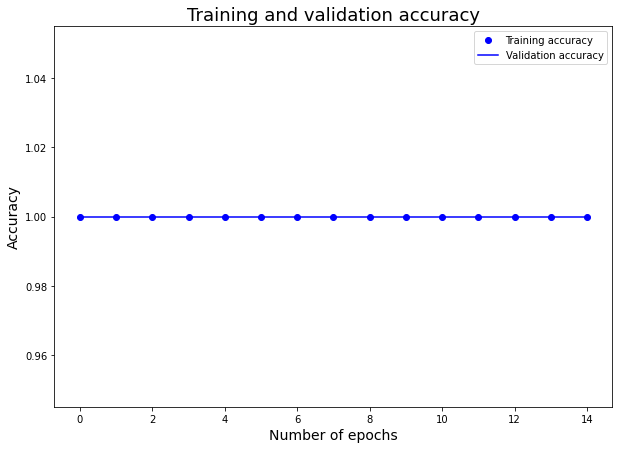

In [29]:
run_model(**params)

In [30]:
params = {}
params['num_species'] = 4
params['num_epochs'] = 5
params['train_batch_size'] = 30
params['valid_batch_size'] = 10
params['learning_rate'] = 0.0001
# params['model'] = create_model()
params['horizontal_flip'] = False
params['rotation_range'] = False # set between 0 and 45 degrees

Found 932 validated image filenames belonging to 4 classes.
Found 20 validated image filenames belonging to 4 classes.
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
      

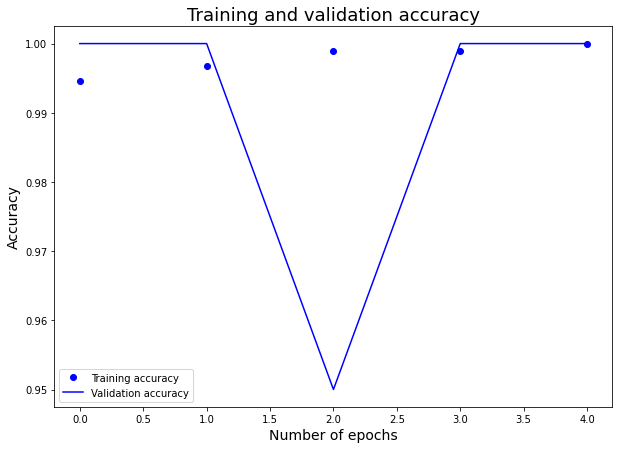

In [31]:
run_model(**params)

In [32]:
params = {}
params['num_species'] = 20
params['num_epochs'] = 5
params['train_batch_size'] = 30
params['valid_batch_size'] = 10
params['learning_rate'] = 0.0001
# params['model'] = create_model()
params['horizontal_flip'] = False
params['rotation_range'] = False # set between 0 and 45 degrees

Found 4123 validated image filenames belonging to 20 classes.
Found 100 validated image filenames belonging to 20 classes.
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
  

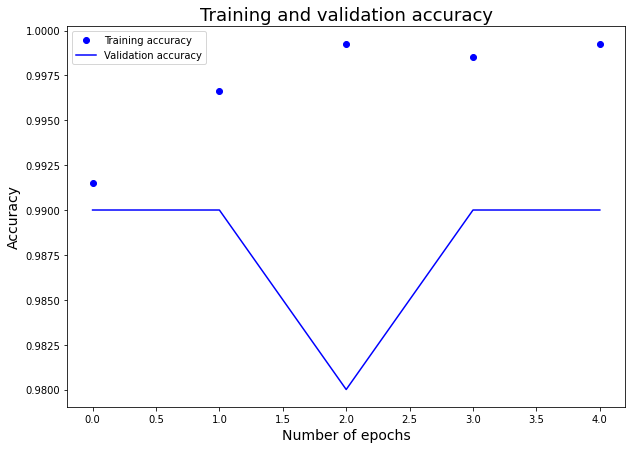

In [33]:
run_model(**params)

In [37]:
params = {}
params['num_species'] = 50
params['num_epochs'] = 5
params['train_batch_size'] = 30
params['valid_batch_size'] = 10
params['learning_rate'] = 0.0001
# params['model'] = create_model()
params['horizontal_flip'] = False
params['rotation_range'] = False # set between 0 and 45 degrees

Found 9458 validated image filenames belonging to 50 classes.
Found 250 validated image filenames belonging to 50 classes.
Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
  

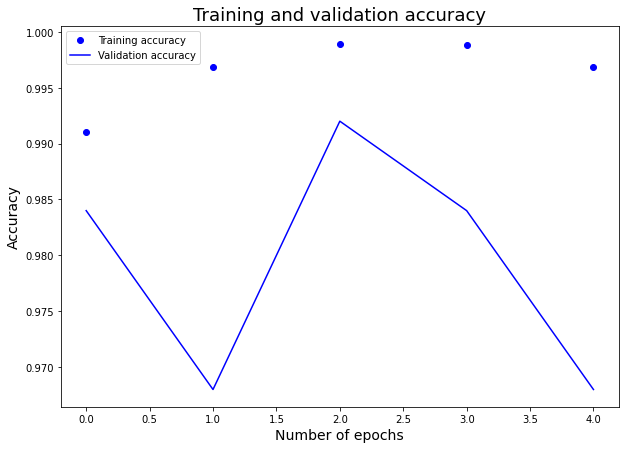

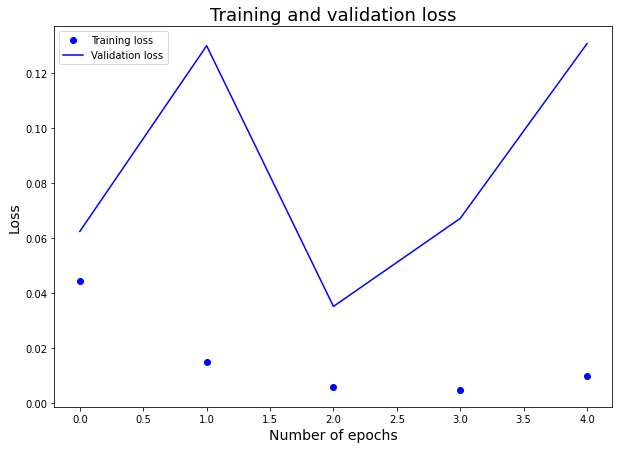

In [38]:
run_model(**params)

Memory error with 100 classes. Further processing will need Google Colab Pro. What about 50 classes?

In [ ]:
params = {}
params['num_species'] = 50
params['num_epochs'] = 5
params['train_batch_size'] = 30
params['valid_batch_size'] = 10
params['learning_rate'] = 0.0001
# params['model'] = create_model()
params['horizontal_flip'] = False
params['rotation_range'] = False # set between 0 and 45 degrees

Found 9458 validated image filenames belonging to 50 classes.
Found 250 validated image filenames belonging to 50 classes.
Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
  

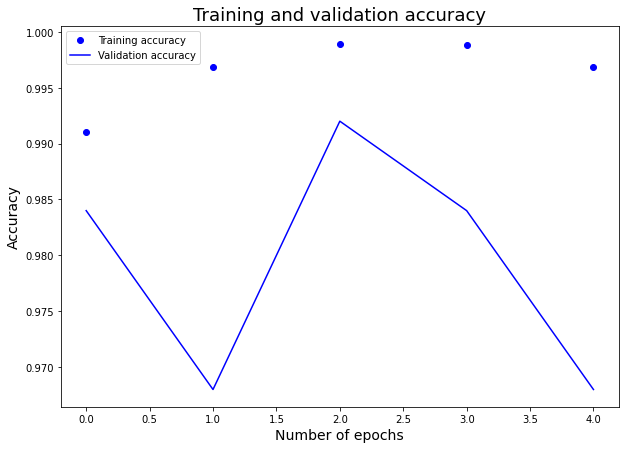

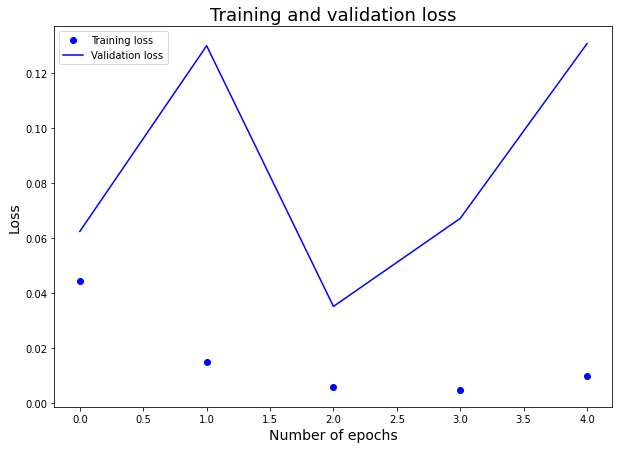

In [ ]:
run_model(**params)

Due to memory constraints, we will use a gradient accumulation optimizer shown in the hidden cell below.

In [49]:
disable_eager_execution()

Fixed error in input dimensions of VGG16

In [16]:
params = {}
params['num_species'] = 50
params['num_epochs'] = 5
params['train_batch_size'] = 30
params['valid_batch_size'] = 10
params['learning_rate'] = 0.0001
# params['model'] = create_model()
params['horizontal_flip'] = False
params['rotation_range'] = False # set between 0 and 45 degrees

Found 9458 validated image filenames belonging to 50 classes.
Found 250 validated image filenames belonging to 50 classes.
58900480/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 bloc

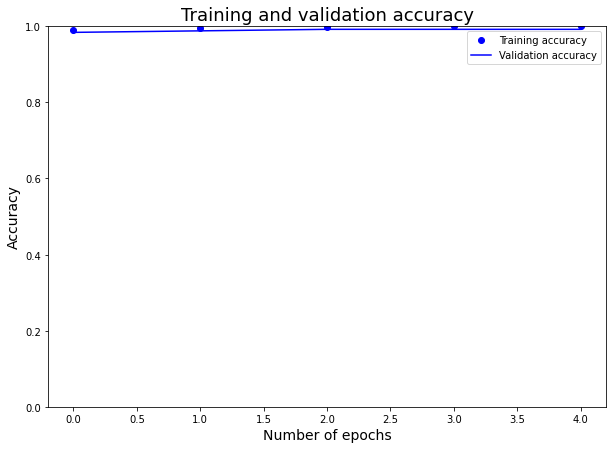

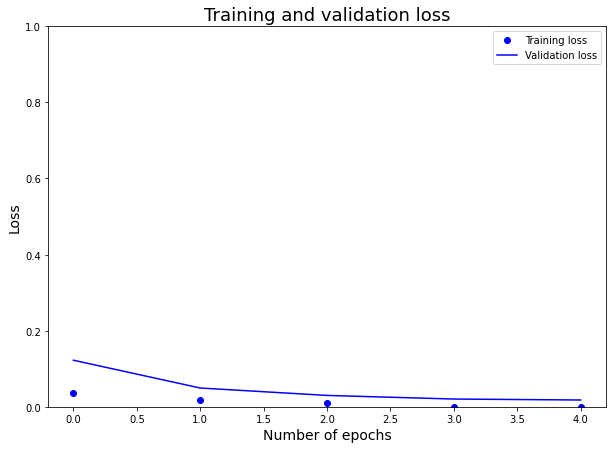

In [17]:
run_model(**params)